# Data Collection and Cleanup
1. Import the libraries used.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, spearmanr, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


2. Clean up the data. Rename columns, remove lacking entries, remove countries with a lot of missing data. 

In [2]:
# data_cleanup.py

# Download the data.
suicide_data = "https://ourworldindata.org/grapher/suicide-rates-by-age-who-mdb.csv?v=1&csvType=full&useColumnShortNames=false"
conflict_data = "https://ourworldindata.org/grapher/states-involved-in-state-based-conflicts.csv?v=1&csvType=full&useColumnShortNames=false"
military_spending_data = "https://ourworldindata.org/grapher/military-spending-as-a-share-of-gdp-sipri.csv?v=1&csvType=full&useColumnShortNames=false"
military_personnel_data = "https://ourworldindata.org/grapher/military-personnel-as-a-share-of-total-population.csv?v=1&csvType=full&useColumnShortNames=false"
police_data = "https://ourworldindata.org/grapher/police-officers-per-1000-people.csv?v=1&csvType=full&useColumnShortNames=false"

# COMMENT THE FIRST BLOCK, REMOVE THE STORAGE OPTION, AND UNCOMMENT BELOW TO USE THE LOCAL DATASETS.
# suicide_data = "datasets/raw/suicide_data.csv"
# conflict_data = "datasets/raw/conflicts_data.csv"
# military_spending_data = "datasets/raw/military_spending_data.csv"
# military_personnel_data = "datasets/raw/military_personnel_data.csv"
# police_data = "datasets/raw/police_data.csv"

# Construct the dataframes.
storage = {'User-Agent': 'Our World In Data data fetch/1.0'}
df = pd.read_csv(suicide_data, storage_options = storage)
conflicts_df = pd.read_csv(conflict_data, storage_options = storage)
military_spending_df = pd.read_csv(military_spending_data, storage_options = storage)
military_personnel_df = pd.read_csv(military_personnel_data, storage_options = storage)
police_df = pd.read_csv(police_data, storage_options = storage)
global_recessions = [1975, 1982, 1991, 2009]

# Save the datasets.
df.to_csv("datasets/raw/suicide_data.csv", index=False)
conflicts_df.to_csv("datasets/raw/conflicts_data.csv", index=False)
military_spending_df.to_csv("datasets/raw/military_spending_data.csv", index=False)
military_personnel_df.to_csv("datasets/raw/military_personnel_data.csv", index=False)
police_df.to_csv("datasets/raw/police_data.csv", index=False)

# Clean up column names.
df = df.rename(columns={"Entity": "Country"})
new_columns = list(df.columns[:3])
for column in df.columns[3:]:
    shorter = column.replace("Death rate from self-inflicted injuries per 100,000 population - Sex: Both sexes - Age group: ", '')
    shorter = shorter.replace(" years", '')
    new_columns.append(shorter)
df.columns = new_columns

# Remove the rows that contain any zeroes.
df = df[df[df.columns[3:]].ne(0).all(axis=1)]

# Merge the datasets and rename the new columns.
df_addition = [conflicts_df, military_spending_df, military_personnel_df ]#, police_df]
col_names = ['Conflict', 'Spending', 'Personnel', 'Police']

for index in range(len(df_addition)):
    df = pd.merge(
        df, df_addition[index][['Code','Year',df_addition[index].columns[3]]], on = ['Code', 'Year'], how = 'left')
    df = df.rename(columns={df.columns[18+index]:col_names[index]})

# The Conflicts column has binary values of type int instead of float.
df['Conflict'] = df['Conflict'].astype('Int64')


# Remove the rows that contain any empty values.
df = df[df[df.columns[3:]].notna().all(axis=1)]

# # Remove countries with less than 30 entries.
counts = df["Country"].value_counts()
kept = counts[counts >= 30].index
df = df[df["Country"].isin(kept)]

# Remove countries missing any years in between.
ranges = df.groupby("Country")["Year"].agg(["min", "max", "count"])
ranges["expected_years"] = ranges["max"] - ranges["min"] + 1
ranges["missing_years"] = ranges["expected_years"] - ranges["count"]

valid = ranges[ranges["missing_years"] == 0].index
df = df[df["Country"].isin(valid)]

# Separately add the police column as it does not have as many rows.
df = pd.merge(df, police_df[['Code', 'Year', police_df.columns[3]]], on = ['Code', 'Year'], how = 'left')
df = df.rename(columns={df.columns[21]:col_names[3]})

# Add recession years.
df['Recession'] = df['Year'].isin(global_recessions).astype(int)

df.to_csv("datasets/suicide_total_data.csv", index=False)

3. Impute the police variable for the focus countries (Canada, United States, United Kingdom) for the year range 2000-2016. It is imputed only in this range as earlier years have too many entries missing police data. 

In [3]:
# impute.py

df = pd.read_csv('datasets/suicide_total_data.csv')

# Countries to impute, they have mostly reliable police data.
countries = ['United States', 'United Kingdom', 'Canada']

# Ensure the police officers column is of type float and filter because only the police officers data for years >= 2000 will be imputed.
df['Police'] = df['Police'].astype(float)
subset = df[(df['Year'] >= 2000) & (df['Country'].isin(countries))]

# Large gaps are not found in this time period and imputation will be uinvariate, so apply forward and backward fill.
df.loc[subset.index, 'Police'] = subset.groupby('Country')['Police'].transform(lambda x: x.ffill().bfill())

df.to_csv("datasets/imputed_suicide_total_data.csv", index=False)

# Exploratory Data Analysis and Hypothesis Testing
4. Analyze the effects of recessions on the suicide rates, both based on age group and total separately. Seek correlation with some lag. Perform a hypothesis test.

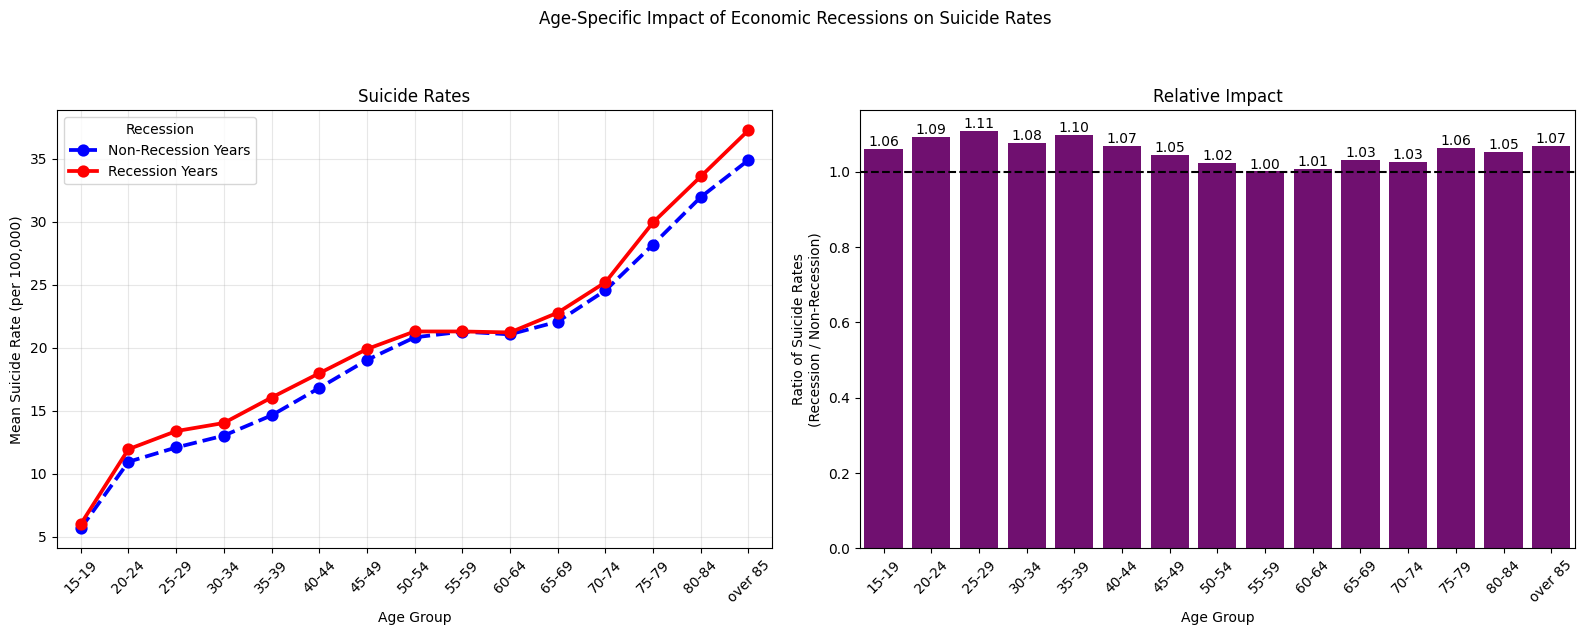

   Age Group  Mean (Non-Recession)  Mean (Recession)  \
0      15-19              5.670014          6.009458   
1      20-24             10.956867         11.953862   
2      25-29             12.090031         13.389762   
3      30-34             13.032732         14.032719   
4      35-39             14.634313         16.050036   
5      40-44             16.809666         17.976121   
6      45-49             19.028093         19.893680   
7      50-54             20.822156         21.291915   
8      55-59             21.280971         21.291632   
9      60-64             21.061543         21.214959   
10     65-69             22.071652         22.777732   
11     70-74             24.544238         25.189446   
12     75-79             28.188064         29.940933   
13     80-84             31.948943         33.582938   
14   over 85             34.883357         37.250484   

    Ratio (Recession/Non-Recession)  T-statistic   p-value  \
0                          1.059867     0

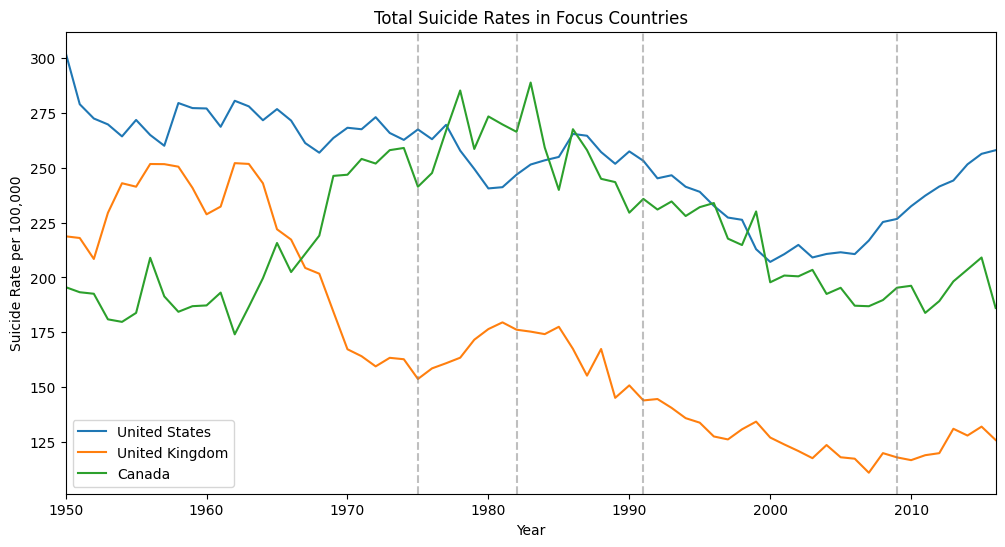

In [4]:
# recession.py

df = pd.read_csv('datasets/imputed_suicide_total_data.csv')
age_cols = df.columns[3:18]

# Prepare data by melting the age columns as they need to be rows.
melted = df.melt(
    id_vars=['Country', 'Year', 'Recession'],
    value_vars=age_cols,
    var_name='Age Group',
    value_name='Suicide Rate'
)

# Convert Age Group to ordered categorical to be in the x axis.
melted['Age Group'] = pd.Categorical(melted['Age Group'], categories=age_cols, ordered=True)

# Create a figure with two plots, both by age groups.  LHS: Recession vs Non-Recession Suicide Rates, RHS: Recession / Non-Recession Suicide Rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Age-Specific Impact of Economic Recessions on Suicide Rates', y=1.05)

# # 1. Absolute Effect Plot (Point Plot)
sns.pointplot(
    x='Age Group',
    y='Suicide Rate',
    hue='Recession',
    data=melted,
    estimator=np.mean,
    errorbar=None,
    palette={0: 'blue', 1: 'red'},
    linestyles=['--', '-'],
    ax=ax1
)
ax1.set_title('Suicide Rates')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Mean Suicide Rate (per 100,000)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Recession', labels=['Non-Recession Years', 'Recession Years'])
ax1.grid(True, alpha=0.3)

# 2. Relative Effect Plot (Bar Plot)
# Calculate recession impact ratio: (recession rate)/(non-recession rate)
recession_effect = melted.groupby(['Age Group', 'Recession'], observed = False)['Suicide Rate'].mean().unstack()
recession_effect['Impact Ratio'] = recession_effect[1] / recession_effect[0]

sns.barplot(
    x=recession_effect.index,
    y='Impact Ratio',
    data=recession_effect.reset_index(),
    color='purple',
    ax=ax2
)
ax2.axhline(1, color='black', linestyle='--')  # Baseline ratio = 1
ax2.set_title('Relative Impact')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Ratio of Suicide Rates\n(Recession / Non-Recession)')
ax2.tick_params(axis='x', rotation=45)

# Annotate bars with ratio values
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.savefig('plots/recession_impact_by_age.png', dpi=300, bbox_inches='tight')
plt.show()


# Hypothesis Test: Two-sample T-Test

results = []

for age_group in age_cols:
    non_recession = melted[(melted['Age Group'] == age_group) & (melted['Recession'] == 0)]['Suicide Rate']
    recession = melted[(melted['Age Group'] == age_group) & (melted['Recession'] == 1)]['Suicide Rate']

    # Run t-test
    t_stat, p_value = ttest_ind(recession, non_recession, equal_var=False)

    # Calculate means
    mean_non_recession = non_recession.mean()
    mean_recession = recession.mean()
    ratio = mean_recession / mean_non_recession

    # Determine significance
    significant = p_value < 0.05

    # Results:
    results.append({
        'Age Group': age_group,
        'Mean (Non-Recession)': mean_non_recession,
        'Mean (Recession)': mean_recession,
        'Ratio (Recession/Non-Recession)': ratio,
        'T-statistic': t_stat,
        'p-value': p_value,
        'Significant (p < 0.05)': significant
    })

results_df = pd.DataFrame(results)
print(results_df)


# 2 YEAR LAGGED ANALYSIS
# Create a 2-year lagged recession column.
df['Recession_lag2'] = df.groupby('Country')['Recession'].shift(-2)
melted_lags = df.melt(
    id_vars=['Country', 'Year', 'Recession', 'Recession_lag2'],
    value_vars=age_cols,
    var_name='Age Group',
    value_name='Suicide Rate'
)
# Initialize results storage.
lag_results = []

for age_group in age_cols:
    # Extract data for 2-year lag
    non_lag = melted_lags[(melted_lags['Age Group'] == age_group) & (melted_lags['Recession_lag2'] == 0)]['Suicide Rate']
    lag = melted_lags[(melted_lags['Age Group'] == age_group) & (melted_lags['Recession_lag2'] == 1)]['Suicide Rate']

    # t-test
    t_stat, p_value = ttest_ind(lag, non_lag, equal_var=False)

    # Store results.
    lag_results.append({
        'Age Group': age_group,
        'Mean (Non-Lag)': non_lag.mean(),
        'Mean (2-Year Lag)': lag.mean(),
        'Ratio': lag.mean() / non_lag.mean(),
        'T-statistic': t_stat,
        'p-value': p_value,
        'Significant (p < 0.05)': p_value < 0.05
    })

print(pd.DataFrame(lag_results))


# Line chart for focus countries.

df['Total_Suicide_Rate'] = df[age_cols].sum(axis=1)

# Filter for focus countries
focus_countries = ['United States', 'United Kingdom', 'Canada']
focus_df = df[df['Country'].isin(focus_countries)]

plt.figure(figsize=(12, 6))
for country in focus_countries:
    country_data = focus_df[focus_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Total_Suicide_Rate'], label=country)

recession_years = [1975, 1982, 1991, 2009]
for year in recession_years:
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.5)

# Adjust plot range and style
plt.xlim(1950, 2016)
plt.title('Total Suicide Rates in Focus Countries')
plt.xlabel('Year')
plt.ylabel('Suicide Rate per 100,000')
plt.legend()
plt.grid(False)  # Remove background grid to highlight recession years.
plt.savefig('plots/recession_focus_countries.png', dpi=300, bbox_inches='tight')
plt.show()

4. Split entries into two groups (conflict vs no conflict country-year) and compare suicide rates. Calculate EDA stats. 

C:\Users\baris.gorur\AppData\Local\Temp\ipykernel_7144\3935469143.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([conflict_data, non_conflict_data],


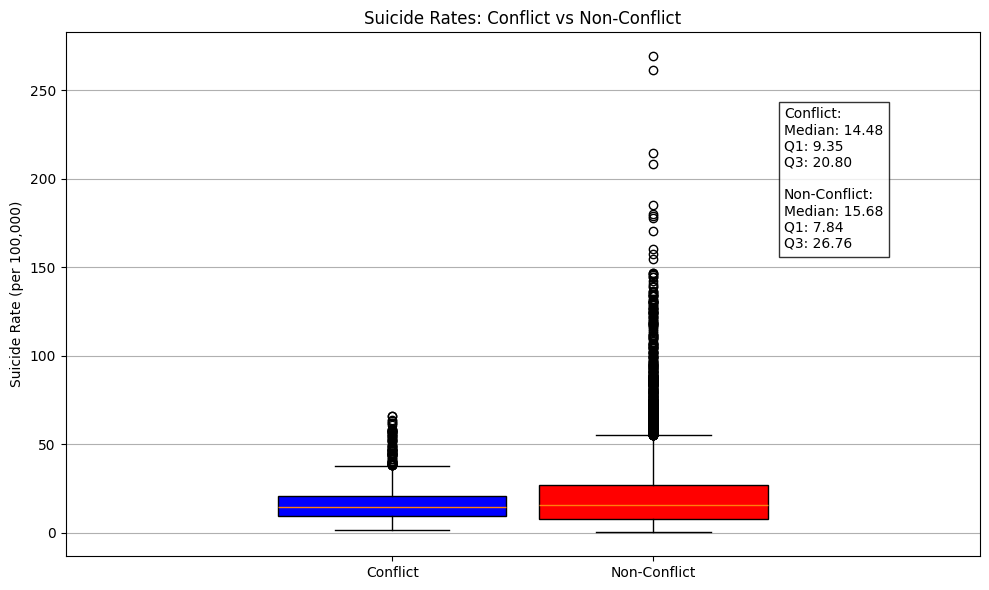

In [5]:
# box_conflict.py

df = pd.read_csv('datasets/imputed_suicide_total_data.csv')

age_cols = df.columns[3:18]
df_melt = pd.melt(df, id_vars=['Conflict'], value_vars=age_cols,
                  var_name='Age Group', value_name='Suicide Rate')

# Separate conflict and non-conflict data.
conflict_data = df_melt[df_melt['Conflict'] == 1]['Suicide Rate']
non_conflict_data = df_melt[df_melt['Conflict'] == 0]['Suicide Rate']

# EDA stats.
conflict_stats = {
    'Median': np.median(conflict_data),
    'Q1': np.percentile(conflict_data, 25),
    'Q3': np.percentile(conflict_data, 75)
}
non_conflict_stats = {
    'Median': np.median(non_conflict_data),
    'Q1': np.percentile(non_conflict_data, 25),
    'Q3': np.percentile(non_conflict_data, 75)
}

# Create box plot.
plt.figure(figsize=(10, 6))
box = plt.boxplot([conflict_data, non_conflict_data],
                  labels=['Conflict', 'Non-Conflict'],
                  positions=[1, 1.4],
                  widths=0.35,
                  patch_artist=True)

box['boxes'][0].set_facecolor('blue')
box['boxes'][1].set_facecolor('red')

plt.title('Suicide Rates: Conflict vs Non-Conflict')
plt.ylabel('Suicide Rate (per 100,000)')
plt.grid(True, axis='y')

# Legend stats.
stats_text = (
    f"Conflict:\n"
    f"Median: {conflict_stats['Median']:.2f}\n"
    f"Q1: {conflict_stats['Q1']:.2f}\n"
    f"Q3: {conflict_stats['Q3']:.2f}\n\n"
    f"Non-Conflict:\n"
    f"Median: {non_conflict_stats['Median']:.2f}\n"
    f"Q1: {non_conflict_stats['Q1']:.2f}\n"
    f"Q3: {non_conflict_stats['Q3']:.2f}"
)
plt.text(1.6, plt.ylim()[1] * 0.85, stats_text,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('plots/conflict_boxplot.png')
plt.show()

5. Do a similar analysis on focus countries sans Canada as it has been mostly not in any conflicts unlike the other two focus countries. Perform a hypothesis test.

C:\Users\baris.gorur\AppData\Local\Temp\ipykernel_7144\2507310344.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Total_Suicide_Rate'] = df_filtered[age_columns].sum(axis=1)


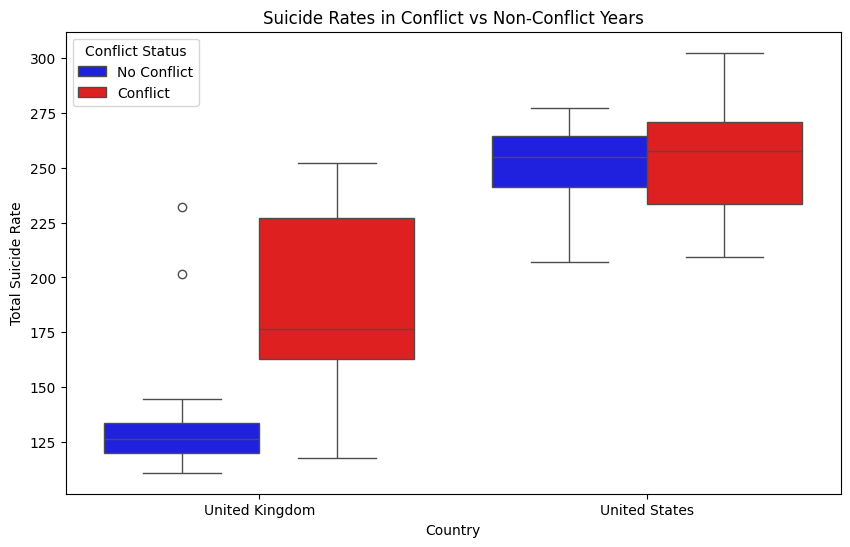

          Country  Mean (Non-Conflict)  Mean (Conflict)     Ratio  \
0  United Kingdom           133.171346       190.933660  1.433744   
1   United States           251.018640       252.197484  1.004696   

   T-statistic       p-value  Significant (p < 0.05)  
0     7.170544  4.846189e-10                    True  
1     0.226009  4.109527e-01                   False  


In [6]:
# focus_conflict.py

# Filter for the US and the UK.
countries = ['United Kingdom', 'United States']
df_filtered = df[df['Country'].isin(countries)]

# Calculate total suicide rate by summing age columns.
age_columns = df.columns[3:18]
df_filtered['Total_Suicide_Rate'] = df_filtered[age_columns].sum(axis=1)

# Create the box plot.
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x='Country',
    y='Total_Suicide_Rate',
    hue='Conflict',
    data=df_filtered,
    palette={1: 'red', 0: 'blue'}
)
plt.title('Suicide Rates in Conflict vs Non-Conflict Years')
plt.ylabel('Total Suicide Rate')
plt.xlabel('Country')

handles, _ = box_plot.get_legend_handles_labels()
box_plot.legend(handles, ['No Conflict', 'Conflict'], title='Conflict Status')

plt.savefig('plots/conflict_focus.png', dpi=300, bbox_inches='tight')
plt.show()


#Hypothesis Test

results = []

for country in ['United Kingdom', 'United States']:
    country_data = df_filtered[df_filtered['Country'] == country]
    non_conflict = country_data[country_data['Conflict'] == 0]['Total_Suicide_Rate']
    conflict = country_data[country_data['Conflict'] == 1]['Total_Suicide_Rate']

    # Run the test (conflict =/= non-conflict).
    t_stat, p_value = ttest_ind(conflict, non_conflict, equal_var=False, alternative='greater')

    # Calculate means and ratio.
    mean_non_conflict = non_conflict.mean()
    mean_conflict = conflict.mean()
    ratio = mean_conflict / mean_non_conflict

    results.append({
        'Country': country,
        'Mean (Non-Conflict)': mean_non_conflict,
        'Mean (Conflict)': mean_conflict,
        'Ratio': ratio,
        'T-statistic': t_stat,
        'p-value': p_value,
        'Significant (p < 0.05)': p_value < 0.05
    })

results_df = pd.DataFrame(results)
print(results_df)

6. Investigate the possible correlation between Military Personnel and Spending data.

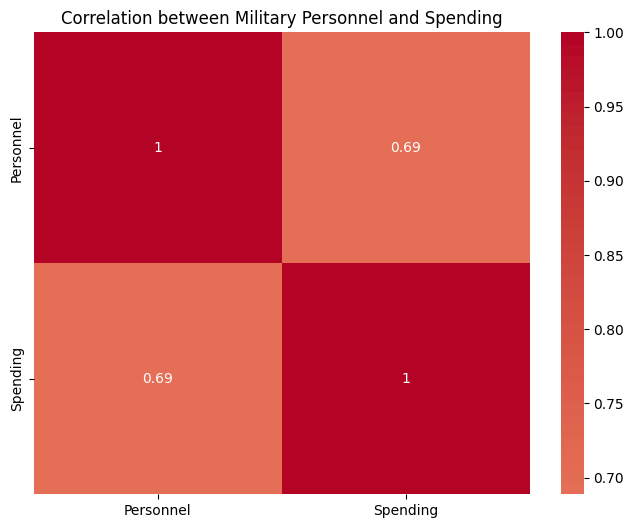

Correlation between Personnel and Spending: 0.689


In [7]:
# military_correlation.py

# Calculate correlation.
correlation = df[['Personnel', 'Spending']].corr()

# Generate the correlation matrix heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Military Personnel and Spending')
plt.savefig('plots/military_cross_correlation.png')
plt.show()

print(f"Correlation between Personnel and Spending: {correlation.loc['Personnel', 'Spending']:.3f}")

7. Analyze the correlation between the two military markers and suicide rates. 

C:\Users\baris.gorur\AppData\Local\Temp\ipykernel_7144\3469373543.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_cols, y=spending_correlations, palette='viridis', ax=ax1)
C:\Users\baris.gorur\AppData\Local\Temp\ipykernel_7144\3469373543.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_cols, y=personnel_correlations, palette='viridis', ax=ax2)


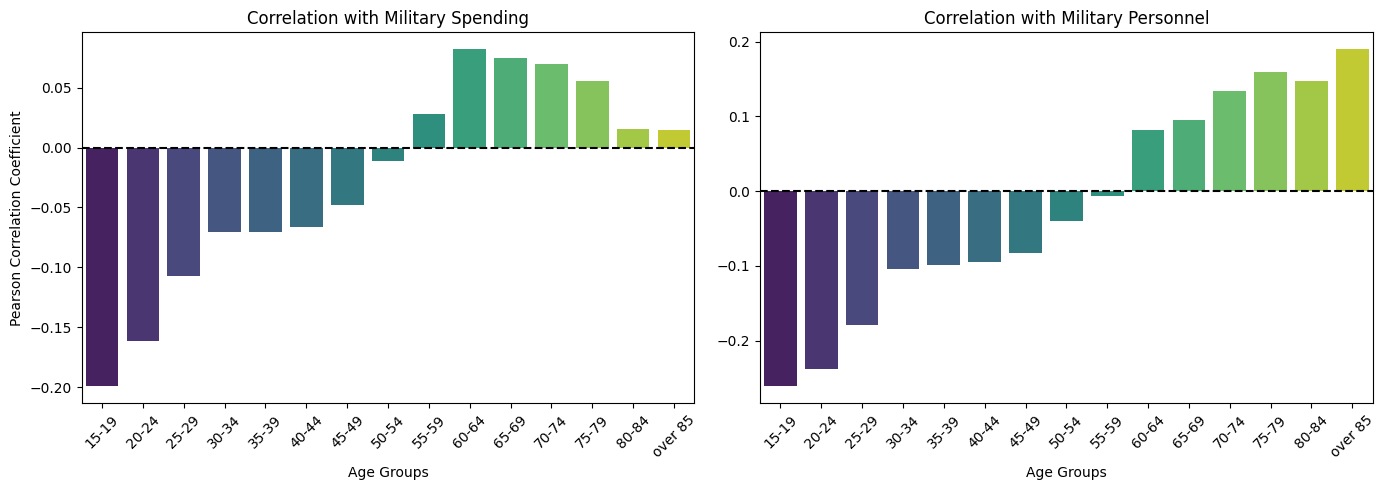

In [8]:
# military_age_correlation.py

# Calculate correlation per age group.
spending_correlations = []
personnel_correlations = []
for age in age_cols:
    spending_corr = df[[age, 'Spending']].corr().iloc[0,1]
    spending_correlations.append(spending_corr)
    corr = df[[age, 'Personnel']].corr().iloc[0,1]
    personnel_correlations.append(corr)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot spending correlations.
sns.barplot(x=age_cols, y=spending_correlations, palette='viridis', ax=ax1)
ax1.set_title('Correlation with Military Spending')
ax1.set_ylabel('Pearson Correlation Coefficient')
ax1.set_xlabel('Age Groups')
ax1.axhline(0, color='black', linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# Plot personnel correlations.
sns.barplot(x=age_cols, y=personnel_correlations, palette='viridis', ax=ax2)
ax2.set_title('Correlation with Military Personnel')
ax2.set_xlabel('Age Groups')
ax2.axhline(0, color='black', linestyle='--')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('plots/military_age_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

8. Seek a correlation between the military markers and suicide rates in focus countries with the use of scatterplots.

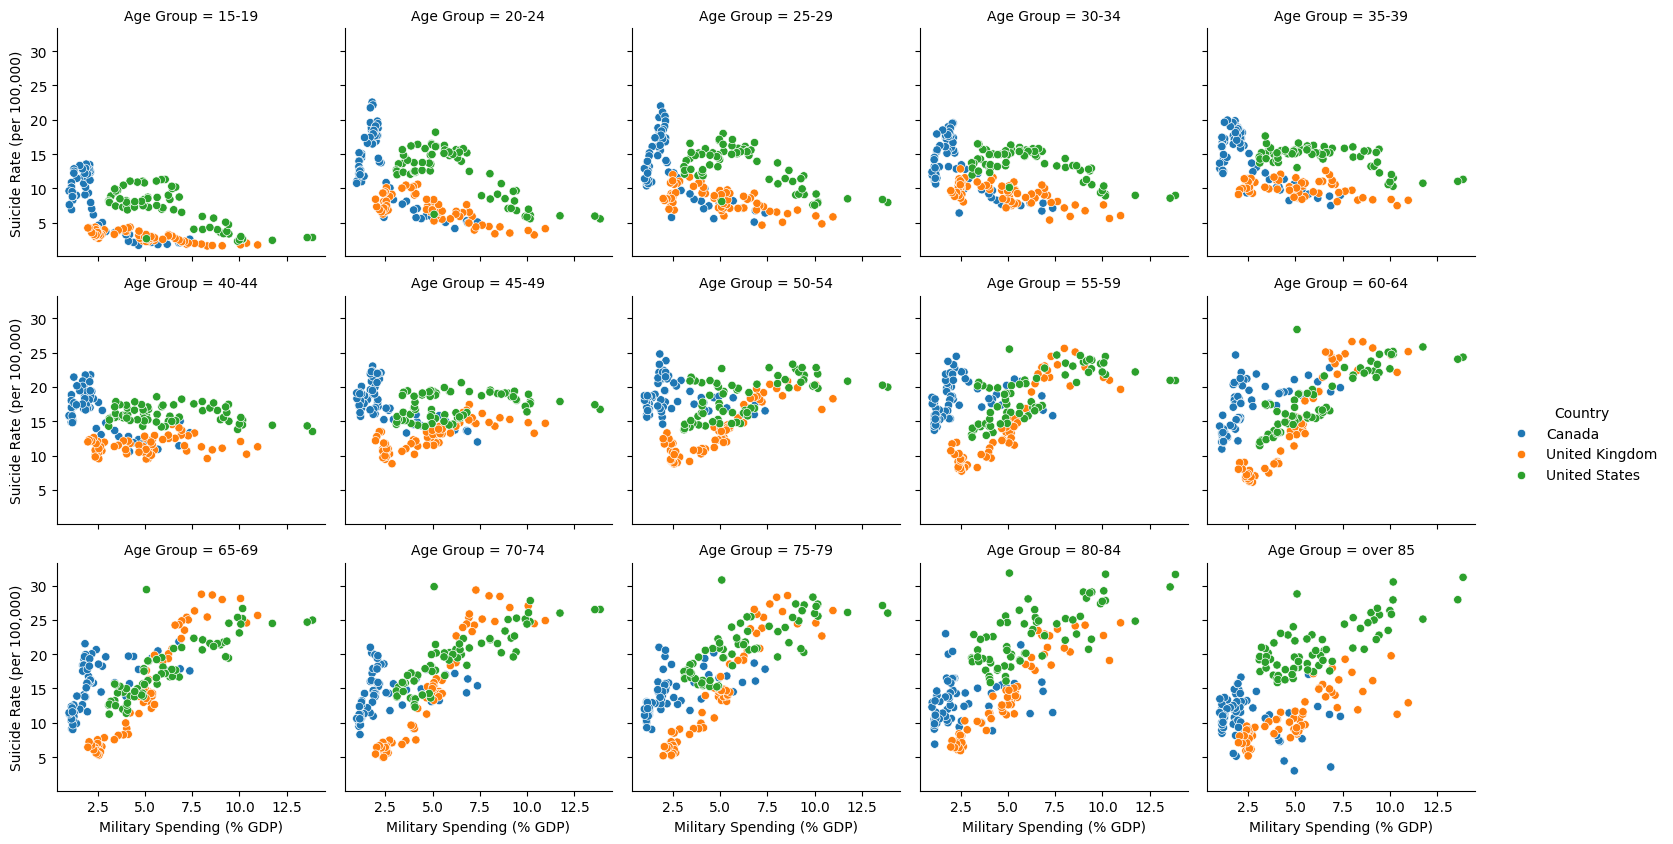

Military Spending

           Country Age Group  Correlation       P-value
44          Canada   over 85    -0.071793  5.637089e-01
23          Canada     50-54     0.063094  6.119931e-01
17          Canada     40-44    -0.368226  2.170622e-03
26          Canada     55-59     0.488267  2.769871e-05
14          Canada     35-39    -0.403664  7.057939e-04
29          Canada     60-64     0.756006  1.404324e-13
11          Canada     30-34    -0.334344  5.687248e-03
20          Canada     45-49    -0.487908  2.813471e-05
32          Canada     65-69     0.713624  1.221742e-11
35          Canada     70-74     0.573150  4.000585e-07
5           Canada     20-24    -0.391851  1.040722e-03
38          Canada     75-79     0.727871  2.988573e-12
2           Canada     15-19    -0.514726  8.340950e-06
41          Canada     80-84     0.410009  5.695050e-04
8           Canada     25-29    -0.347314  3.981627e-03
34  United Kingdom     70-74     0.946883  9.780198e-34
37  United Kingdom     75-79 

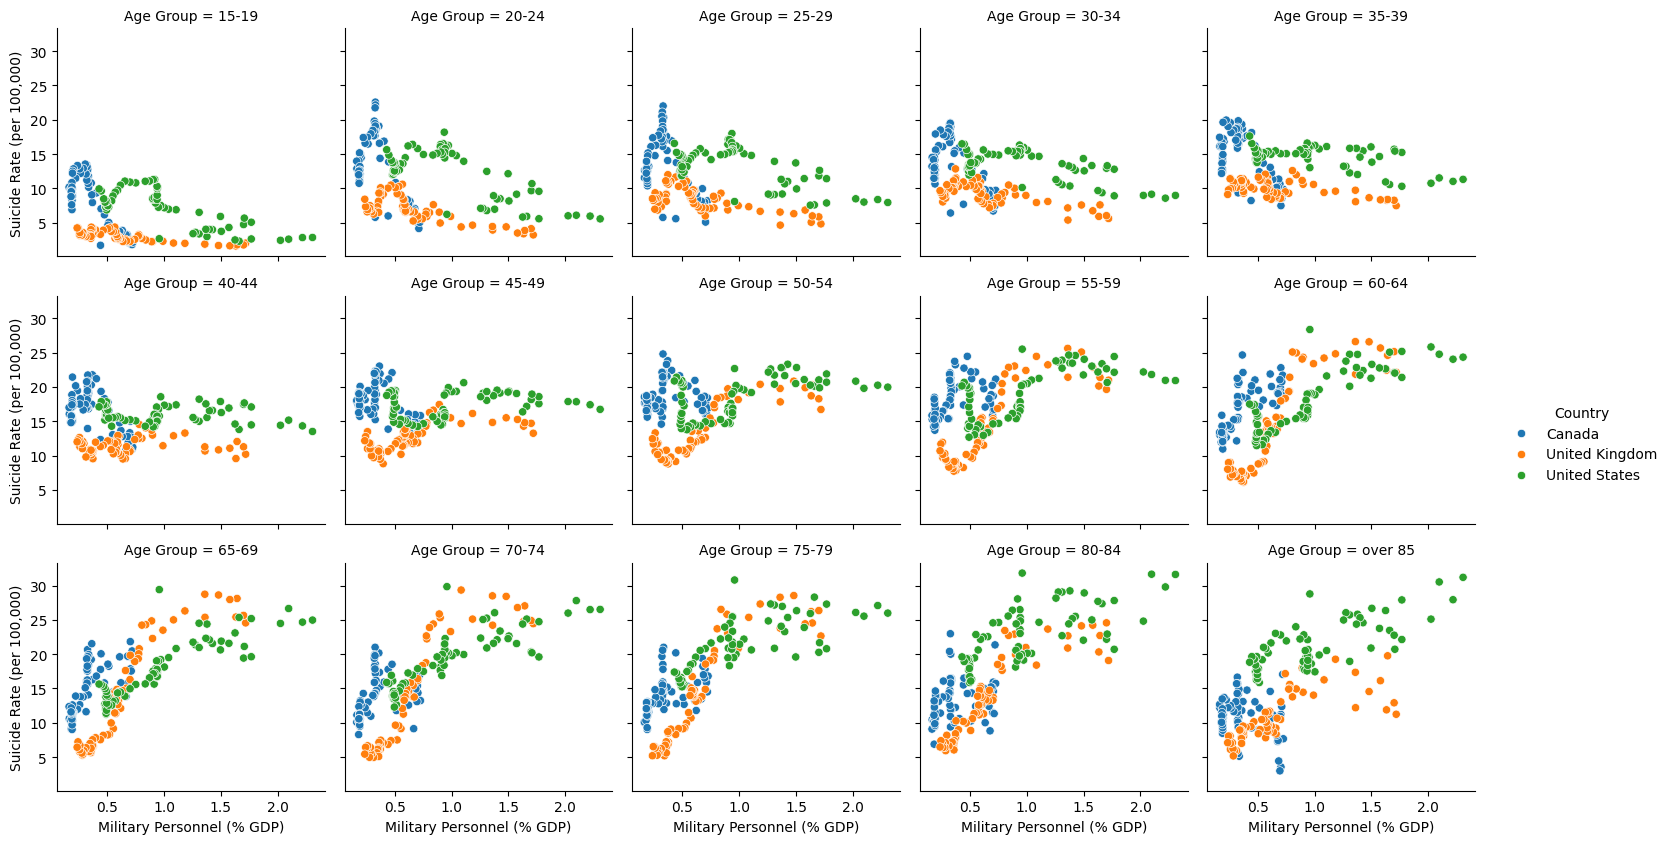

Military Personnel

           Country Age Group  Correlation       P-value
44          Canada   over 85    -0.173118  1.612228e-01
23          Canada     50-54     0.175672  1.550363e-01
17          Canada     40-44    -0.305731  1.187029e-02
26          Canada     55-59     0.584165  2.108581e-07
14          Canada     35-39    -0.349030  3.793937e-03
29          Canada     60-64     0.805970  1.918158e-16
11          Canada     30-34    -0.354059  3.288364e-03
20          Canada     45-49    -0.354258  3.269601e-03
32          Canada     65-69     0.769335  2.844847e-14
35          Canada     70-74     0.587078  1.772954e-07
5           Canada     20-24    -0.352622  3.426311e-03
38          Canada     75-79     0.693551  7.737162e-11
2           Canada     15-19    -0.533602  3.325302e-06
41          Canada     80-84     0.362080  2.605139e-03
8           Canada     25-29    -0.324208  7.438967e-03
34  United Kingdom     70-74     0.959733  1.473045e-37
37  United Kingdom     75-79

In [9]:
# focus_spending.py

# Filter for selected countries
countries = ['United States', 'United Kingdom', 'Canada']
df_filtered = df[df['Country'].isin(countries)]

# MILITARY SPENDING

# Melt age group columns.
age_cols = df_filtered.columns[3:18]
df_melted = df_filtered.melt(id_vars=['Country', 'Year', 'Spending'],
                            value_vars=age_cols,
                            var_name='Age Group',
                            value_name='Suicide Rate')

# Create facet grid of scatterplots.
g = sns.FacetGrid(df_melted, col='Age Group', col_wrap=5, height=3)
g.map_dataframe(sns.scatterplot, x='Spending', y='Suicide Rate', hue='Country')
g.set_axis_labels('Military Spending (% GDP)', 'Suicide Rate (per 100,000)')
g.add_legend(title='Country', bbox_to_anchor=(1.004, 0.45), loc='center right', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig('plots/focus_spending_age_correlation.png')
plt.show()


# Perform Spearman test for each age group.
results = []
for age_group in age_cols:
    for country in countries:
        country_data = df_filtered[df_filtered['Country'] == country]
        corr, pval = spearmanr(country_data['Spending'], country_data[age_group])
        results.append({
            'Country': country,
            'Age Group': age_group,
            'Correlation': corr,
            'P-value': pval
        })

# Create results dataframe and print.
results_df = pd.DataFrame(results)
print("Military Spending\n")
print(results_df.sort_values(by='Country'))


# MILITARY PERSONNEL

# Melt age group columns.
age_cols = df_filtered.columns[3:18]
df_melted = df_filtered.melt(id_vars=['Country', 'Year', 'Personnel'],
                            value_vars=age_cols,
                            var_name='Age Group',
                            value_name='Suicide Rate')

# Create facet grid of scatterplots.
g = sns.FacetGrid(df_melted, col='Age Group', col_wrap=5, height=3)
g.map_dataframe(sns.scatterplot, x='Personnel', y='Suicide Rate', hue='Country')
g.set_axis_labels('Military Personnel (% GDP)', 'Suicide Rate (per 100,000)')
g.add_legend(title='Country', bbox_to_anchor=(1.004, 0.45), loc='center right', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig('plots/focus_personnel_age_correlation.png')
plt.show()


# Perform Spearman test for each age group.
results = []
for age_group in age_cols:
    for country in countries:
        country_data = df_filtered[df_filtered['Country'] == country]
        corr, pval = spearmanr(country_data['Personnel'], country_data[age_group])
        results.append({
            'Country': country,
            'Age Group': age_group,
            'Correlation': corr,
            'P-value': pval
        })

# Create results dataframe and print.
results_df = pd.DataFrame(results)
print("Military Personnel\n")
print(results_df.sort_values(by='Country'))

9. See how the number of police officers per population correlates with suicide rates in the focus countries from 2000 to 2016, with a limited scope due to data unavailability. 

C:\Users\baris.gorur\AppData\Local\Temp\ipykernel_7144\840162226.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Total_Suicide_Rate'] = df_filtered[age_cols].mean(axis=1)


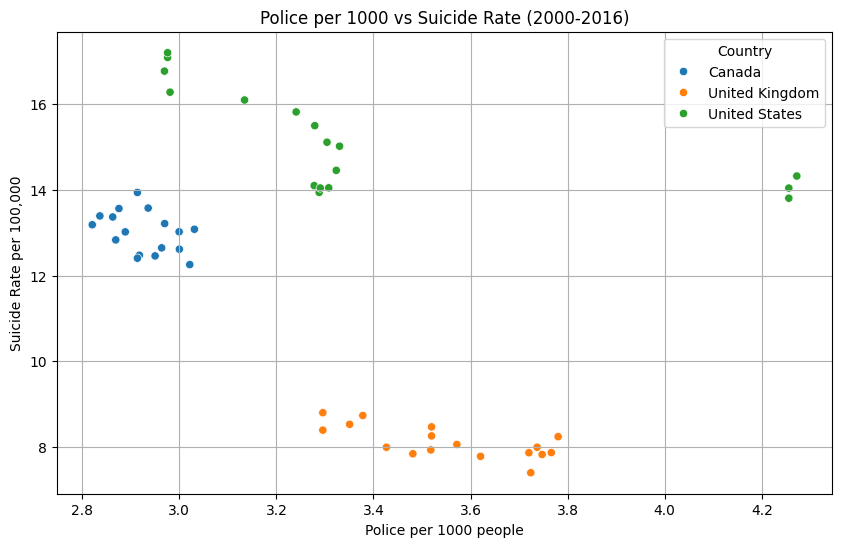

United States: Pearson r = -0.659, p-value = 0.004
United Kingdom: Pearson r = -0.696, p-value = 0.002
Canada: Pearson r = -0.403, p-value = 0.109


In [10]:
# police.py

df_filtered = df[(df['Country'].isin(countries)) & (df['Year'] >= 2000) & (df['Year'] <= 2016)]

# Calculate total suicide rate.
age_cols = df_filtered.columns[3:18]

df_filtered['Total_Suicide_Rate'] = df_filtered[age_cols].mean(axis=1)

# Plot.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Police', y='Total_Suicide_Rate', hue='Country')
plt.title('Police per 1000 vs Suicide Rate (2000-2016)')
plt.xlabel('Police per 1000 people')
plt.ylabel('Suicide Rate per 100,000')
plt.grid(True)
plt.savefig('plots/focus_police_correlation.png')
plt.show()

# Calculate Pearson correlation for each country.
for country in countries:
    country_data = df_filtered[df_filtered['Country'] == country]
    corr, p_value = pearsonr(country_data['Police'], country_data['Total_Suicide_Rate'])
    print(f"{country}: Pearson r = {corr:.3f}, p-value = {p_value:.3f}")

# Machine Learning
10. Prepare the data and use Random Forest and XGBoost to see how (relatively) good of a predictor each marker (variable) is for all countries in the entire year range. Combine the two military markers and see their effect compared to recession years. Compare the two models.  


Random Forest Results:
RMSE = 1.1399, R-squared = 0.8555

XGBoost Results:
RMSE = 1.1940, R-squared = 0.8293


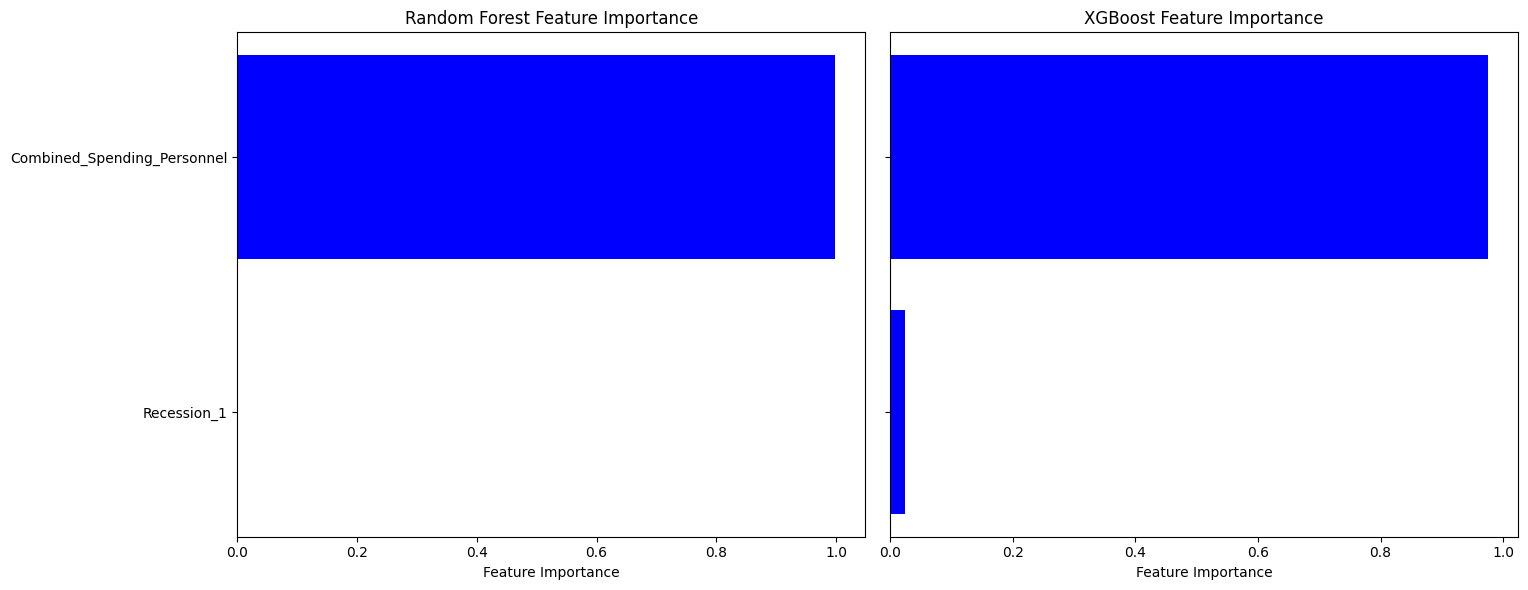

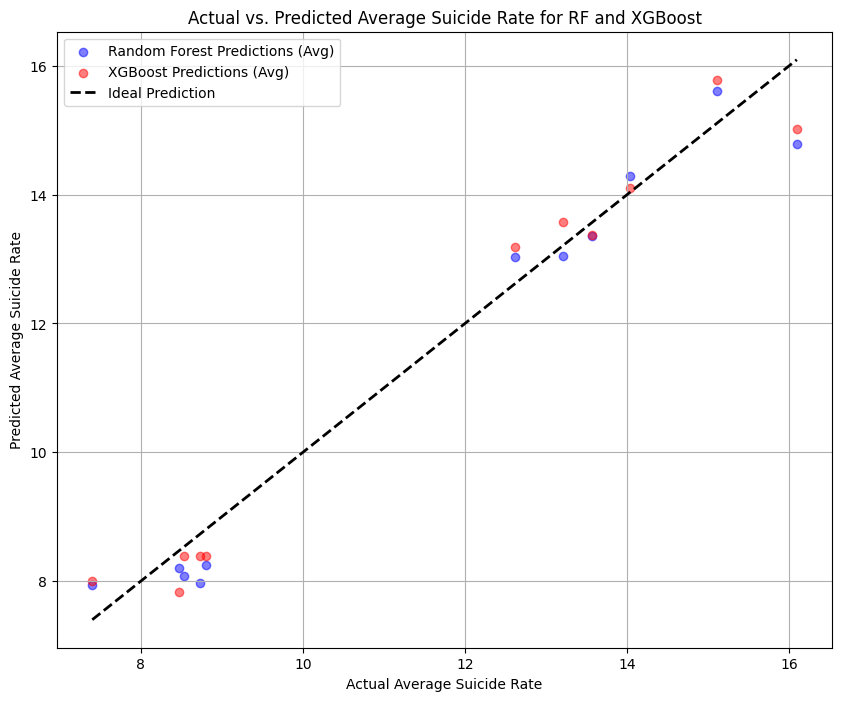

In [15]:
# ml_all.py

features = ['Spending', 'Personnel', 'Recession']
age_cols = df.columns[3:18].tolist()

# Recession is categorical.
df['Recession'] = df['Recession'].astype(str)

X = df[features]
y_multi = df[age_cols]

# Define numerical and categorical features
numerical_features = ['Spending', 'Personnel']
categorical_features = ['Recession']

# Create a combined feature.
scaler = StandardScaler()
df['Scaled_Spending'] = scaler.fit_transform(df[['Spending']])
df['Scaled_Personnel'] = scaler.fit_transform(df[['Personnel']])
df['Combined_Spending_Personnel'] = (df['Scaled_Spending'] + df['Scaled_Personnel']) / 2

features_combined = ['Combined_Spending_Personnel', 'Recession']

# Create preprocessor.
preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Combined_Spending_Personnel']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# Update X to use the new feature set.
X_combined = df[features_combined]

# Split the data.
X_combined_train, X_combined_test, y_multi_train, y_multi_test = train_test_split(
    X_combined, y_multi, test_size=0.2, random_state=42
)

# Random Forest.
rf_multi_pipeline_combined = Pipeline(steps=[('preprocessor', preprocessor_combined),
                                             ('regressor', RandomForestRegressor(n_estimators=500, random_state=1))])
rf_multi_pipeline_combined.fit(X_combined_train, y_multi_train)
y_pred_rf_multi_combined = rf_multi_pipeline_combined.predict(X_combined_test)

print("\nRandom Forest Results:")
rmse_rf_multi_combined = np.sqrt(mean_squared_error(y_multi_test, y_pred_rf_multi_combined))
r2_rf_multi_combined = r2_score(y_multi_test, y_pred_rf_multi_combined)
print(f"RMSE = {rmse_rf_multi_combined:.4f}, R-squared = {r2_rf_multi_combined:.4f}")

# XGBoost.
xgb_multi_pipeline_combined = Pipeline(steps=[('preprocessor', preprocessor_combined),
                                              ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=1))])
xgb_multi_pipeline_combined.fit(X_combined_train, y_multi_train)
y_pred_xgb_multi_combined = xgb_multi_pipeline_combined.predict(X_combined_test)

print("\nXGBoost Results:")
rmse_xgb_multi_combined = np.sqrt(mean_squared_error(y_multi_test, y_pred_xgb_multi_combined))
r2_xgb_multi_combined = r2_score(y_multi_test, y_pred_xgb_multi_combined)
print(f"RMSE = {rmse_xgb_multi_combined:.4f}, R-squared = {r2_xgb_multi_combined:.4f}")

# Feature Importance Plots.
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Random Forest Feature Importance.
fitted_preprocessor_rf = rf_multi_pipeline_combined.named_steps['preprocessor']
num_feature_names_rf = ['Combined_Spending_Personnel']
cat_feature_names_rf = list(fitted_preprocessor_rf.named_transformers_['cat'].get_feature_names_out(categorical_features))
preprocessed_feature_names_rf = num_feature_names_rf + cat_feature_names_rf
rf_feature_importances = rf_multi_pipeline_combined.named_steps['regressor'].feature_importances_
feature_importance_dict_rf = dict(zip(preprocessed_feature_names_rf, rf_feature_importances))
sorted_feature_importance_rf = sorted(feature_importance_dict_rf.items(), key=lambda item: item[1], reverse=False)
features_sorted_rf, importances_sorted_rf = zip(*sorted_feature_importance_rf)

axes[0].barh(features_sorted_rf, importances_sorted_rf, color='blue')
axes[0].set_xlabel("Feature Importance")
axes[0].set_title("Random Forest Feature Importance")

# XGBoost Feature Importance.
fitted_preprocessor_xgb = xgb_multi_pipeline_combined.named_steps['preprocessor']
num_feature_names_xgb = ['Combined_Spending_Personnel']
cat_feature_names_xgb = list(fitted_preprocessor_xgb.named_transformers_['cat'].get_feature_names_out(categorical_features))
preprocessed_feature_names_xgb = num_feature_names_xgb + cat_feature_names_xgb
xgb_feature_importances = xgb_multi_pipeline_combined.named_steps['regressor'].feature_importances_
feature_importance_dict_xgb = dict(zip(preprocessed_feature_names_xgb, xgb_feature_importances))
sorted_feature_importance_xgb = sorted(feature_importance_dict_xgb.items(), key=lambda item: item[1], reverse=False)
features_sorted_xgb, importances_sorted_xgb = zip(*sorted_feature_importance_xgb)

axes[1].barh(features_sorted_xgb, importances_sorted_xgb, color='blue')
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("XGBoost Feature Importance")

plt.tight_layout()
plt.subplots_adjust(left=0.190)
plt.savefig('plots/ml_all_importance.png', dpi=300, bbox_inches='tight')
plt.show()


#Actual vs Predicted Rates Plot.
actual_average_suicide_rate_test = y_multi_test.mean(axis=1)
predicted_average_suicide_rate_rf = y_pred_rf_multi_combined.mean(axis=1)
predicted_average_suicide_rate_xgb = y_pred_xgb_multi_combined.mean(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(actual_average_suicide_rate_test, predicted_average_suicide_rate_rf, alpha=0.5, label='Random Forest Predictions (Avg)', color='blue')
plt.scatter(actual_average_suicide_rate_test, predicted_average_suicide_rate_xgb, alpha=0.5, label='XGBoost Predictions (Avg)', color='red')
plt.xlabel("Actual Average Suicide Rate")
plt.ylabel("Predicted Average Suicide Rate")
plt.title("Actual vs. Predicted Average Suicide Rate for RF and XGBoost")
# Ideal line.
max_rate = max(actual_average_suicide_rate_test.max(), predicted_average_suicide_rate_rf.max(), predicted_average_suicide_rate_xgb.max())
min_rate = min(actual_average_suicide_rate_test.min(), predicted_average_suicide_rate_rf.min(), predicted_average_suicide_rate_xgb.min())
plt.plot([min_rate, max_rate], [min_rate, max_rate], 'k--', lw=2, label='Ideal Prediction')

plt.grid(True)
plt.legend()
plt.savefig('plots/ml_all_performance.png', dpi=300, bbox_inches='tight')
plt.show()

11. Perform a similar analysis, this time for focus countries for the years 2000 to 2016 with all the variables acting as predictors.


Random Forest Results:
RMSE = 0.8289, R-squared = 0.9260

XGBoost Results:
RMSE = 0.9030, R-squared = 0.9081


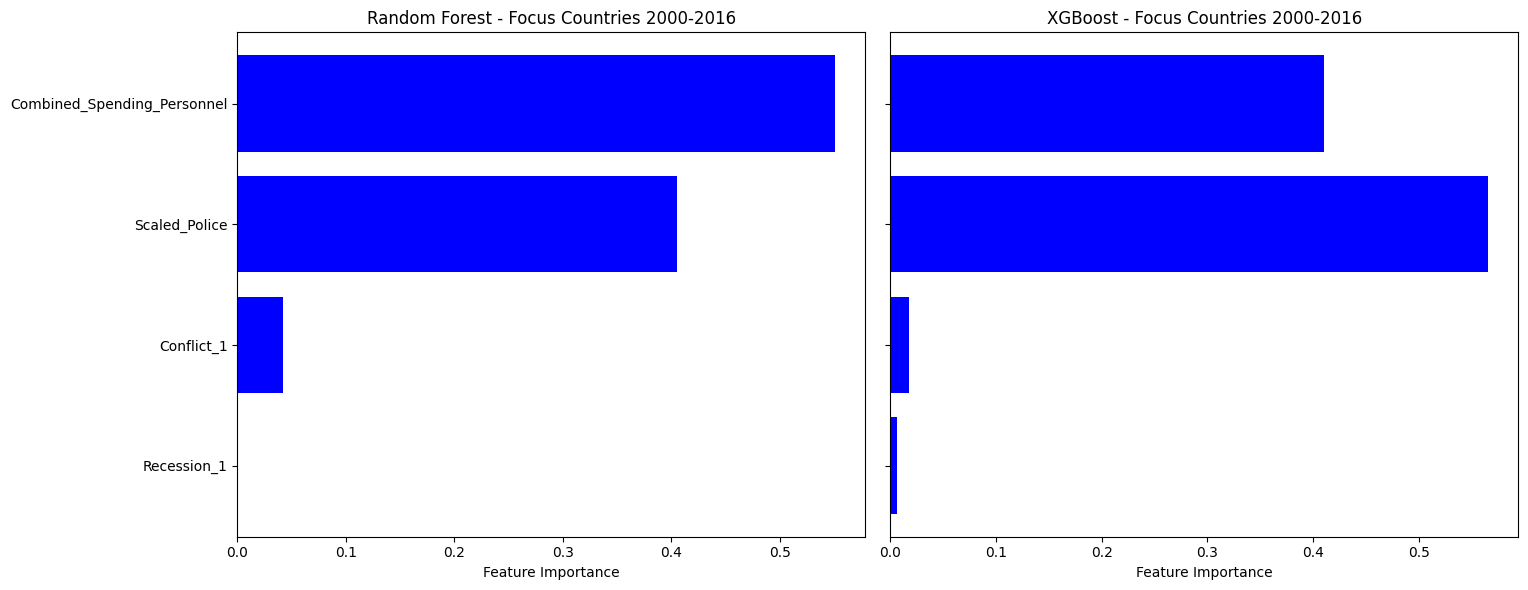

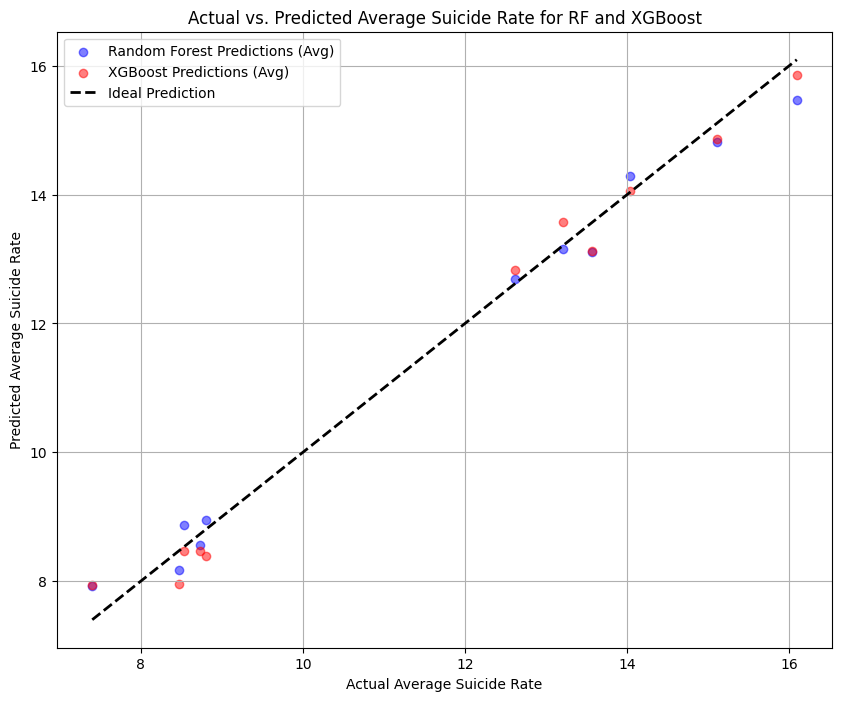

In [16]:
# ml_focus.py

df = pd.read_csv('datasets/imputed_suicide_total_data.csv')

df = df[(df['Country'].isin(countries)) & (df['Year'] >= 2000) & (df['Year'] <= 2016)]

features = ['Spending', 'Personnel', 'Police', 'Recession', 'Conflict']
age_cols = df.columns[3:18].tolist()

# Recession and Conflict are categorical.
df['Recession'] = df['Recession'].astype(str)
df['Conflict'] = df['Conflict'].astype(str)

# Create a combined feature and scale numerical variables.
scaler = StandardScaler()
df['Scaled_Spending'] = scaler.fit_transform(df[['Spending']])
df['Scaled_Personnel'] = scaler.fit_transform(df[['Personnel']])
df['Combined_Spending_Personnel'] = (df['Scaled_Spending'] + df['Scaled_Personnel']) / 2
df['Scaled_Police'] = scaler.fit_transform(df[['Police']])

features_combined = ['Combined_Spending_Personnel', 'Scaled_Police', 'Recession', 'Conflict']

X = df[features_combined]
y_multi = df[age_cols]

# Define numerical and categorical features.
numerical_features = ['Combined_Spending_Personnel', 'Scaled_Police']
categorical_features = ['Recession', 'Conflict']

# Create preprocessor.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Already scaled
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])

# Split the data.
X_train, X_test, y_multi_train, y_multi_test = train_test_split(
    X, y_multi, test_size=0.2, random_state=42
)

# Random Forest.
rf_multi_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500, random_state=1))
])
rf_multi_pipeline.fit(X_train, y_multi_train)
y_pred_rf_multi = rf_multi_pipeline.predict(X_test)

print("\nRandom Forest Results:")
rmse_rf_multi = np.sqrt(mean_squared_error(y_multi_test, y_pred_rf_multi))
r2_rf_multi = r2_score(y_multi_test, y_pred_rf_multi)
print(f"RMSE = {rmse_rf_multi:.4f}, R-squared = {r2_rf_multi:.4f}")

# XGBoost.
xgb_multi_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=1))
])
xgb_multi_pipeline.fit(X_train, y_multi_train)
y_pred_xgb_multi = xgb_multi_pipeline.predict(X_test)

print("\nXGBoost Results:")
rmse_xgb_multi = np.sqrt(mean_squared_error(y_multi_test, y_pred_xgb_multi))
r2_xgb_multi = r2_score(y_multi_test, y_pred_xgb_multi)
print(f"RMSE = {rmse_xgb_multi:.4f}, R-squared = {r2_xgb_multi:.4f}")

# Feature Importance Plots.
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Random Forest Feature Importance.
fitted_preprocessor_rf = rf_multi_pipeline.named_steps['preprocessor']
num_feature_names_rf = numerical_features
cat_feature_names_rf = list(fitted_preprocessor_rf.named_transformers_['cat'].get_feature_names_out(categorical_features))
preprocessed_feature_names_rf = num_feature_names_rf + cat_feature_names_rf
rf_feature_importances = rf_multi_pipeline.named_steps['regressor'].feature_importances_
feature_importance_dict_rf = dict(zip(preprocessed_feature_names_rf, rf_feature_importances))
sorted_feature_importance_rf = sorted(feature_importance_dict_rf.items(), key=lambda item: item[1], reverse=False)
features_sorted_rf, importances_sorted_rf = zip(*sorted_feature_importance_rf)

axes[0].barh(features_sorted_rf, importances_sorted_rf, color='blue')
axes[0].set_xlabel("Feature Importance")
axes[0].set_title("Random Forest - Focus Countries 2000-2016")

# XGBoost Feature Importance.
fitted_preprocessor_xgb = xgb_multi_pipeline.named_steps['preprocessor']
num_feature_names_xgb = numerical_features
cat_feature_names_xgb = list(fitted_preprocessor_xgb.named_transformers_['cat'].get_feature_names_out(categorical_features))
preprocessed_feature_names_xgb = num_feature_names_xgb + cat_feature_names_xgb
xgb_feature_importances = xgb_multi_pipeline.named_steps['regressor'].feature_importances_
feature_importance_dict_xgb = dict(zip(preprocessed_feature_names_xgb, xgb_feature_importances))
sorted_feature_importance_xgb = sorted(feature_importance_dict_xgb.items(), key=lambda item: item[1], reverse=False)
features_sorted_xgb, importances_sorted_xgb = zip(*sorted_feature_importance_xgb)

axes[1].barh(features_sorted_xgb, importances_sorted_xgb, color='blue')
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("XGBoost - Focus Countries 2000-2016")

plt.tight_layout()
plt.subplots_adjust(left=0.190)
plt.savefig('plots/ml_focus_importance.png', dpi=300, bbox_inches='tight')
plt.show()

#Actual vs Predicted Rates Plot.
actual_average_suicide_rate_test = y_multi_test.mean(axis=1)
predicted_average_suicide_rate_rf = y_pred_rf_multi.mean(axis=1)
predicted_average_suicide_rate_xgb = y_pred_xgb_multi.mean(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(actual_average_suicide_rate_test, predicted_average_suicide_rate_rf,
            alpha=0.5, label='Random Forest Predictions (Avg)', color='blue')
plt.scatter(actual_average_suicide_rate_test, predicted_average_suicide_rate_xgb,
            alpha=0.5, label='XGBoost Predictions (Avg)', color='red')
plt.xlabel("Actual Average Suicide Rate")
plt.ylabel("Predicted Average Suicide Rate")
plt.title("Actual vs. Predicted Average Suicide Rate for RF and XGBoost")
# Ideal Line.
max_rate = max(actual_average_suicide_rate_test.max(), predicted_average_suicide_rate_rf.max(), predicted_average_suicide_rate_xgb.max())
min_rate = min(actual_average_suicide_rate_test.min(), predicted_average_suicide_rate_rf.min(), predicted_average_suicide_rate_xgb.min())
plt.plot([min_rate, max_rate], [min_rate, max_rate], 'k--', lw=2, label='Ideal Prediction')

plt.grid(True)
plt.legend()
plt.savefig('plots/ml_focus_performance.png', dpi=300, bbox_inches='tight')
plt.show()